In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import h5py
import time
# print(torch.__version__)
file_name = "../data/CIFAR10.hdf5"
data = h5py.File(file_name, "r")
# get metadata for data: [n for n in data.keys()]
x_train = np.float32(data["X_train"][:]).reshape(-1, 3, 32, 32)
y_train = np.int32(np.array(data["Y_train"]))
x_test = np.float32(data["X_test"][:]).reshape(-1, 3, 32, 32)
y_test = np.int32(np.array(data["Y_test"]))
data.close()

In [2]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 3, 32, 32), (50000,), (10000, 3, 32, 32), (10000,))

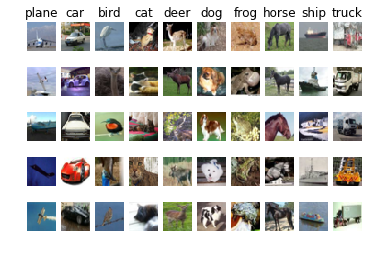

In [3]:
import matplotlib.pyplot as plt
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * len(classes) + y + 1
        plt.subplot(samples_per_class, len(classes), plt_idx)
        plt.imshow(x_train[idx].transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
class CNN_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.batch_norm1 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.batch_norm2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.batch_norm3 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.batch_norm4 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.batch_norm5 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        #print("con0: x shape{}".format(x.shape))
        x = F.relu(self.conv1(x))
        #print("con1: x shape{}".format(x.shape))
        x = self.batch_norm1(x)
        x = F.relu(self.conv2(x))
        #print("con2: x shape{}".format(x.shape))
        x = F.dropout2d(F.max_pool2d(x, kernel_size=2, stride=2), p=0.25)
        #print("maxpool1: x shape{}".format(x.shape))
        x = F.relu(self.conv3(x))
        #print("con3: x shape{}".format(x.shape))
        x = self.batch_norm2(x)
        x = F.relu(self.conv4(x))
        #print("con4: x shape{}".format(x.shape))
        x = F.dropout2d(F.max_pool2d(x, kernel_size=2, stride=2), p=0.25)
        #print("maxpool2: x shape{}".format(x.shape))
        x = F.relu(self.conv5(x))
        #print("con5: x shape{}".format(x.shape))
        x = self.batch_norm3(x)
        x = F.relu(self.conv6(x))
        #print("con6: x shape{}".format(x.shape))
        x = F.dropout2d(x, p=0.25)
        x = F.relu(self.conv7(x))
        #print("con7: x shape{}".format(x.shape))
        x = self.batch_norm4(x)
        x = F.relu(self.conv8(x))
        #print("con8: x shape{}".format(x.shape))
        x = self.batch_norm5(x)
        x = F.dropout2d(x, p=0.25)
        #print("final: x shape{}".format(x.shape))
        x = x.view(-1, self.fc1.in_features)
        #print("flatten: x shape{}".format(x.shape))
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
x_train = torch.from_numpy(x_train)
# y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
# y_test = torch.from_numpy(y_test)
model = CNN_torch()
optimizer = optim.SGD(model.parameters(), lr=0.1)
batch_size = 100
num_epoch = 5
L_Y_train = len(y_train)
model.train()
train_loss = []

In [6]:
x_train_sub = x_train[0:1000]
y_train_sub = y_train[0:1000]
L_Y_train = len(y_train_sub)
for epoch in range(num_epoch):
    index_permutation = np.random.permutation(L_Y_train)
    x_train_sub = x_train_sub[index_permutation, :]
    y_train_sub = y_train_sub[index_permutation]
    train_accuracy = []
    for i in range(0, L_Y_train, batch_size):
        x_train_batch = torch.FloatTensor(x_train_sub[i:i+batch_size, :])
        y_train_batch = torch.LongTensor(y_train_sub[i:i+batch_size])
        data, target = Variable(x_train_batch), Variable(y_train_batch)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_loss.append(loss.item())#loss.data[0] version conflict
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = (float(prediction.eq(target.data).sum()) / float(batch_size))
        train_accuracy.append(accuracy)
    accuracy_epcoh = np.mean(train_accuracy)
    print(epoch+1, accuracy_epcoh)

1 0.21600000000000003
2 0.317
3 0.33599999999999997
4 0.392
5 0.45699999999999996
